In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import operator
import itertools
import scipy.stats as stats
import pymit
from tqdm import tqdm
import traceback
from category_encoders import one_hot, target_encoder
import joblib

In [103]:
def calc_y(df):
    th = np.round(df['feature_goodness'].describe()['75%'],4)
    df['y'] = 0
    df.loc[df['feature_goodness'] >= th, 'y'] = 1
    return df

In [104]:
import glob


all_dfs = []
for file in glob.glob("ExploreKit/*meta*.df"):
    thisdf = joblib.load(file)
    thisdf = calc_y(thisdf.copy())
    all_dfs.append(thisdf)

In [105]:
final_df = pd.concat(all_dfs)

In [106]:
final_df.index = final_df.feature_name

In [107]:
final_df = final_df.drop(['feature_name', 'feature_goodness', 'dataset', 'V30_avg_t', 'V30_std_t', 'V30_max_t', 'V30_min_t'], axis=1)

In [108]:
def clean_df(df, taret, positive_target):
    
    def remove_collinear_features(x, threshold=0.8):
        '''
        Objective:
            Remove collinear features in a dataframe with a correlation coefficient
            greater than the threshold. Removing collinear features can help a model 
            to generalize and improves the interpretability of the model.

        Inputs: 
            x: features dataframe
            threshold: features with correlations greater than this value are removed

        Output: 
            dataframe that contains only the non-highly-collinear features
        '''

        # Calculate the correlation matrix
        corr_matrix = x.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []

        # Iterate through the correlation matrix and compare correlations
        for i in iters:
            for j in range(i+1):
                item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
                col = item.columns
                row = item.index
                val = abs(item.values)

                # If correlation exceeds the threshold
                if val >= threshold:
                    # Print the correlated features and the correlation value
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    drop_cols.append(col.values[0])

        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        print(f"Dropped cols: {drops} by corr")
        x = x.drop(columns=drops)

        return x
    
    def clean_target(df, target, positive_target):
        df.loc[df[target] != positive_target, target] = 0
        df.loc[df[target] == positive_target, target] = 1
        y_all = df[[target]].astype(int)
        X_all = df.drop([target], axis=1)
        return X_all, y_all
    
    def nulls(df, th_del=0.8, th_mean=0.2):
        df = df.replace([np.inf, -np.inf], np.nan)
        null = df.isnull().sum().sort_values()[::-1]
        null = null[null > 0] / len(df)
        null = pd.concat([df[null.index].dtypes, null],axis=1)
        null.columns=['dtype', 'ratio_null']
        null.index.name = 'feature'
        dict_ops = {}
        if null.empty:
            return df
        
        for idx, row in null.iterrows():
            
            if row['ratio_null'] > th_del:
                df = df.drop(idx, axis=1)
            
            elif row['ratio_null'] < th_mean and  row['dtype'] != 'object':
                df[idx] = df[idx].fillna(df[idx].mean())
            
            else:
                if row['dtype'] == 'object':
                    df[idx] = df[idx].fillna('my_nan_value')
                else:
                    df[idx] = df[idx].fillna(df[idx].min()*1000)
        
        return df
    
    def clean_groups(df, target, max_group_size=0):
        is_object = ['object']
        object_features = list(df.select_dtypes(include=is_object).columns)
        if target in object_features:
            object_features.remove(target)
        for col in object_features:
            try:
                df[col] = df[col].astype(float)
            except:
                len_unique = len(df[col].unique())
                if len_unique < max_group_size:
                    df = df.rename({col: f"{col}_group"},axis=1)
                else:
                    df = df.rename({col: f"{col}_mean_encode"},axis=1)
        return df
                    
        
    
    df = nulls(df.copy())
    df = clean_groups(df.copy(), target)
#     df = remove_collinear_features(df.copy(), threshold=0.9)
    X_all, y_all = clean_target(df.copy(), target, positive_target)
    return X_all, y_all

def prepare_bases_to_modeling(X_train_ori, X_test_ori):
    
    one_hot_cols = [x for x in X_train_ori.columns if 'group' in x]
    mean_encoding_cols = [x for x in X_train_ori.columns if 'encode' in x]

    if len(one_hot_cols) > 0:
        enc = one_hot.OneHotEncoder(cols=one_hot_cols, drop_invariant=True)
        X_train_ori = enc.fit_transform(X_train_ori.copy())
        joblib.dump(enc, 'ExploreKit/enc_onehot_pred')
        X_test_ori = enc.transform(X_test_ori.copy())
#         X_train = X_train.drop(ORIGINAL_FEATURES, axis=1)
#         X_train = pd.concat([X_train, X_train_ori], axis=1)
#         X_test = pd.concat([X_test, X_test_ori], axis=1)

    if len(mean_encoding_cols) > 0:
        enc = target_encoder.TargetEncoder(cols=mean_encoding_cols, drop_invariant=True)
        X_train_ori = training_numeric_dataset = enc.fit_transform(X_train_ori.copy(), y_train)
        joblib.dump(enc, 'ExploreKit/enc_mean_pred')
        X_test_ori = testing_numeric_dataset = enc.transform(X_test_ori.copy())
#         X_train = X_train.drop(ORIGINAL_FEATURES, axis=1)
#         X_train = pd.concat([X_train, X_train_ori], axis=1)
#         X_test = pd.concat([X_test, X_test_ori], axis=1)
    
    return X_train_ori, X_test_ori
    

In [109]:
target='y'
positive_target=1
X_all, y_all = clean_df(final_df.copy(), target, positive_target)


In [112]:
X_all.columns

Index(['num_sources', 'num_numeric_sources', 'num_discrete_sources',
       'discretizer_in_use', 'normalizer_in_use', 'group_in_use',
       'binary_in_use', 'max_discrete_source_value',
       'min_discrete_source_value', 'avg_discrete_source_value',
       'std_discrete_source_value', 'max_chi_source_opattr_value',
       'min_chi_source_opattr_value', 'avg_chi_source_opattr_value',
       'std_chi_source_opattr_value', 'max_numeric_source_value',
       'min_numeric_source_value', 'avg_numeric_source_value',
       'std_numeric_source_value', 'max_ttest_source_opattr_value',
       'min_ttest_source_opattr_value', 'avg_ttest_source_opattr_value',
       'std_ttest_source_opattr_value', 'feat_mutual_info', 'num_instances',
       'num_features', 'num_numeric_attr', 'num_discrete_attr',
       'ratio_numeric_attr', 'ratio_discrete_attr', 'f1_0.4', 'precision_0.4',
       'recall_0.4', 'f1_0.45', 'precision_0.45', 'recall_0.45', 'f1_0.5',
       'precision_0.5', 'recall_0.5', 'f1_0.6'

In [110]:
X_train_ori, X_test_ori, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.3, random_state = 0)
X_train_ori, X_test_ori = prepare_bases_to_modeling(X_train_ori.copy(), X_test_ori.copy())

In [72]:
core_params  = {'num_boost_round': 1000, 'verbose_eval':True}

hyper_params_clf = {    
    'task': 'train',
    'objective': 'binary:logistic',
    'metric': 'binary_error',
    'learning_rate':  0.1,
    'num_leaves': 24,
    'colsample_bytree': 0.7,
    'lambda': 0.02
}

In [73]:
from fangorn.training import classifiers

this_clf = classifiers.xgb_classifier(train_set= [X_train_ori, y_train],
                     test_set= [X_test_ori, y_test],
                     features= X_train_ori.columns,
                     core_params=core_params,
                     hyper_params=hyper_params_clf,
                     target= target,
                     test_metrics= ['auc', 'precision', 'recall', 'f1'],
                     project_name= 'explore_kit'
                     ) 
this_auc = this_clf['calc_metrics']['auc']

[14:23:01] WARNING: ../src/learner.cc:541: 
Parameters: { metric, num_leaves, task } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:23:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [174]:
from fangorn.training import classifiers

coreparams ={'bootstrap': True,
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300,
            'class_weight':"balanced"}
                
this_clf = classifiers.random_forest_classifier(train_set= [X_train_ori, y_train],
                     test_set= [X_test_ori, y_test],
                     features= X_train_ori.columns,
                     core_params=coreparams,
#                      hyp;er_params=hyper_params_clf,
                     target= target,
                     test_metrics= ['auc', 'precision', 'recall', 'f1'],
                     project_name= 'explore_kit'
                     ) 
this_auc = this_clf['calc_metrics']['auc']

In [74]:
preds_df = this_clf['df_with_preds']

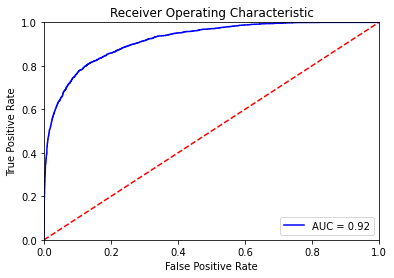

In [75]:
def calc_metrics(y_true, y_pred, th):
    def acc(y_true, y_pred, th):
        from sklearn.metrics import accuracy_score
        y_pred = list(map(lambda k: 0 if k<=th else 1, y_pred))
        return accuracy_score(y_true, y_pred)

    def f1(y_true, y_pred, th):
        from sklearn.metrics import f1_score
        y_pred = list(map(lambda k: 0 if k<=th else 1, y_pred))
        return f1_score(y_true, y_pred)

    def precision(y_true, y_pred, th):
        from sklearn.metrics import precision_score
        y_pred = list(map(lambda k: 0 if k<=th else 1, y_pred))
        return precision_score(y_true, y_pred, average='macro') 

    def recall(y_true, y_pred, th):
        from sklearn.metrics import recall_score
        y_pred = list(map(lambda k: 0 if k<=th else 1, y_pred))
        return recall_score(y_true, y_pred, average='macro')

    def auc(y_true, y_pred, th):
        from sklearn.metrics import roc_auc_score
        return roc_auc_score(y_true, y_pred)
    
    dict_metrics = {}
    dict_metrics['acc'] = acc(y_true, y_pred, th)
    dict_metrics['f1'] = f1(y_true, y_pred, th)
    dict_metrics['precision'] = precision(y_true, y_pred, th)
    dict_metrics['recall'] = recall(y_true, y_pred, th)
    dict_metrics['auc'] = auc(y_true, y_pred, th)
    return dict_metrics

import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(preds_df['real_value'], preds_df['preds'].values)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [14]:
calc_metrics(preds_df['real_value'].values, preds_df['preds'].values, 0.37)

{'acc': 0.9076166320805472,
 'f1': 0.7330075521990227,
 'precision': 0.8504598139473138,
 'recall': 0.8280452562933371,
 'auc': 0.9339031983742053}

In [77]:
def plot_curves(y_real, y_preds, th):
    y_pred = list(map(lambda k: 0 if k<=th else 1, y_pred))

In [78]:
pr, rec, ths = metrics.precision_recall_curve(preds_df['real_value'].values, preds_df['preds'].values)

In [79]:
rec = [np.round(x, 4) for x in rec]

In [80]:
import matplotlib.pyplot as pyplot

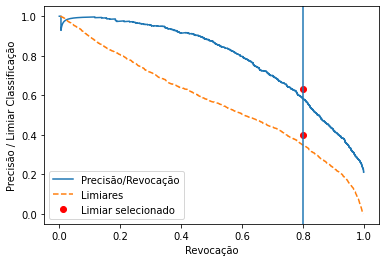

In [81]:
# pyplot.plot(pr, label='precisão')
pyplot.plot(rec, pr, label='Precisão/Revocação')
pyplot.plot(ths, rec[:-1], linestyle='--', label='Limiares')
pyplot.plot(0.8, 0.63, 'ro', label='Limiar selecionado')
pyplot.plot(0.8, 0.4, 'ro')

pyplot.axvline(x=0.8, ymin=0, ymax=1)


# pyplot.plot(ths, label='limiar')
# axis labels
pyplot.xlabel('Revocação')
pyplot.ylabel('Precisão / Limiar Classificação')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [82]:
import joblib
joblib.dump(this_clf['model_object'], 'ExploreKit/rank_model_xgb')

['ExploreKit/rank_model_xgb']

In [83]:
joblib.dump(this_clf['df_with_preds'], 'ExploreKit/df_rank_model_preds')

['ExploreKit/df_rank_model_preds']

In [87]:
dict_ops = {}
for col in X_train_ori.columns:
    dict_ops[f'mean_{col}'] = X_train_ori[col].mean()

In [89]:
joblib.dump(dict_ops, 'ExploreKit/dict_means_predict')

['ExploreKit/dict_means_predict']